In [20]:
import os
import glob
import pandas as pd
import numpy as np
import json
import cv2
import pickle

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

from collections import Counter
from notebook_utils import initialize_environment
initialize_environment()

from utils.data_loading.load_data import get_tile_data

from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [10]:
import Utils.EvaluationMetrics as EvalUtils

In [2]:
data_directory = "../data/context_data/"
json_directory = "../data/json_files_trimmed_features/"

game_data_path="../data/game_data.csv"
train_data_path="../data/train_data.csv"
test_data_path="../data/test_data.csv"

EPOCHS=10
BATCH_SIZE=25
LATENT_DIM=256

In [54]:
# data loading

def get_pickle_file(path):
    with open(path,"rb") as handle:
        return pickle.load(handle)

data=pd.read_csv(game_data_path)
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

data['features'] = data.features.apply(lambda x: literal_eval(str(x)))
train_data['features'] = train_data.features.apply(lambda x: literal_eval(str(x)))
test_data['features'] = test_data.features.apply(lambda x: literal_eval(str(x)))

# loading multi-label binarizer
mlb=get_pickle_file("../model/model_tokenizer.pickle")
print("Feature Dictionary Loaded")
total_features = len(mlb.classes_)
print("The feature dictionary has size", total_features)
display("Features", mlb.classes_)

# loading the batches
# training 
train_image_batch=get_pickle_file("../data/train_image_batch.pickle")
train_text_batch=get_pickle_file("../data/train_text_batch.pickle")
output_image_batch=get_pickle_file("../data/output_image_batch.pickle")
output_text_batch=get_pickle_file("../data/output_text_batch.pickle")

#testing
test_image_batch=get_pickle_file("../data/test_image_batch.pickle")
test_text_batch=get_pickle_file("../data/test_text_batch.pickle")

print("Training Testing Batches loaded")

print("Train Image batch shape", train_image_batch.shape)
print("Train Text batch shape", train_text_batch.shape)
print("Train Output Image batch shape", output_image_batch.shape)
print("Train Output Text batch shape", output_text_batch.shape)

print("Test Image batch shape", test_image_batch.shape)
print("Test Text batch shape", test_text_batch.shape)   

Feature Dictionary Loaded
The feature dictionary has size 13


/home/surfytom/miniconda3/envs/DissEnv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.24.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


'Features'

array(['block', 'breakable', 'climbable', 'collectable', 'element',
       'empty', 'hazard', 'moving', 'openable', 'passable', 'pipe',
       'solid', 'wall'], dtype=object)

Training Testing Batches loaded
Train Image batch shape (22854, 48, 48, 3)
Train Text batch shape (22854, 13)
Train Output Image batch shape (22854, 16, 16, 3)
Train Output Text batch shape (22854, 13)
Test Image batch shape (2540, 48, 48, 3)
Test Text batch shape (2540, 13)


In [34]:
def LoadTrainTestData(pathToDataCsv, testSetSize=0.1, shuffle=False, randomState=1):

    dataFrame = pd.read_csv(pathToDataCsv)

    dataFrame['affordances'] = dataFrame['affordances'].apply(lambda x: literal_eval(str(x)))
    dataFrame['tiles'] = dataFrame['tiles'].apply(lambda x: np.array(literal_eval(str(x))))

    return train_test_split(dataFrame, test_size=testSetSize, random_state=randomState, shuffle=shuffle)

def LoadCrossValTrainTestData(pathToDataCsv, shuffle=False, randomState=1):

    crossValDataDict = {}

    dataFrame = pd.read_csv(pathToDataCsv)

    dataFrame['affordances'] = dataFrame['affordances'].apply(lambda x: literal_eval(str(x)))
    dataFrame['tiles'] = dataFrame['tiles'].apply(lambda x: np.array(literal_eval(str(x))))

    if shuffle:
        dataFrame = dataFrame.sample(frac=1, random_state=randomState).reset_index()

    for gameName in dataFrame['gamename'].unique():
        testData = dataFrame[dataFrame['gamename'] == gameName]
        trainData = dataFrame.drop(testData.index)
        
        crossValDataDict[gameName] = {"trainData": trainData, "testData": testData}
    
    return crossValDataDict

In [38]:
# Loading standard train test split
trainData, testData = LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)

In [4]:
def TextTileToImage(tileArray, tileSize, spritePath, savePath=None):

    outputImage = np.empty((tileSize*tileArray.shape[0], tileSize*tileArray.shape[1], 3), dtype=np.uint8)

    fileName = ""

    for i, row in enumerate(tileArray):
        for j, tile in enumerate(row):

            tile = '@' if tile == '.' else tile
            fileName += tile

            tileImage = cv2.cvtColor(cv2.imread(f"{spritePath}/{tile}.png"), cv2.COLOR_BGR2RGB)
            outputImage[i*tileSize:(i+1)*tileSize, j*tileSize:(j+1)*tileSize] = tileImage

    if savePath:
        cv2.imwrite(f"{savePath}/{fileName}.png", outputImage)

    return outputImage

In [39]:
spritePaths = {
    "kidicarus": "../data/tomData/sprites/kidicarus", 
    "loderunner": "../data/tomData/sprites/loderunner",
    "megaman": "../data/tomData/sprites/megaman",
    "supermariobros": "../data/tomData/sprites/supermariobros",
    "thelegendofzelda": "../data/tomData/sprites/thelegendofzelda",
}

# trainImages = []

# trainImages = np.empty(shape=(trainData.shape[0], 48, 48, 3), dtype=np.uint8)
# for index, row in trainData.iterrows():
#     #print(f"{index}: {row['gamename']}")
#     trainImages.append(TextTileToImage(row['tiles'], 16, spritePaths[row['gamename']]))

# trainData["image"] = trainImages

# Does the same thing as above but faster
trainData["image"] = [TextTileToImage(row['tiles'], 16, spritePaths[row['gamename']]) for index, row in trainData.iterrows()]

In [40]:
trainData.head()

,Unnamed: 0,gamename,tiles,affordances,image
15235,14353,loderunner,"[[b, b, b], [-, -, #], [G, G, #]]","[passable, climbable]","[[[255, 0, 0], [255, 0, 0], [255, 0, 0], [255,..."
3994,3112,loderunner,"[[-, ., .], [., #, b], [., #, b]]","[passable, climbable]","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3267,2385,loderunner,"[[-, -, #], [-, -, #], [., ., #]]","[passable, climbable]","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1315,433,loderunner,"[[#, #, b], [#, b, b], [b, b, B]]","[solid, breakable]","[[[0, 0, 0], [0, 0, 0], [255, 255, 255], [255,..."
1488,606,loderunner,"[[#, ., #], [#, -, #], [b, -, B]]","[passable, climbable]","[[[0, 0, 0], [0, 0, 0], [255, 255, 255], [255,..."


In [7]:
#initialise the TF-IDF vectorizer to counter imbalanced dataset
vectorizer = TfidfVectorizer(stop_words=None)
train_data_copy = train_data
train_data_copy["features"] = train_data_copy.features.apply(lambda x: str(x))
vectors = vectorizer.fit_transform(train_data_copy["features"])
idf = vectorizer.idf_
print(idf)
print(vectorizer.vocabulary_.keys())
new_dict = {}
for c in mlb.classes_:
    if c in vectorizer.vocabulary_.keys():
        new_dict[c] = idf[vectorizer.vocabulary_[c]]
    else:
        print(f"No vocab key: {c}")
        new_dict[c] = np.max(idf)
print(new_dict)
print("\n Printing the TF-IDF for the labels\n\n", new_dict)
weight_freq = {k: v / sum(new_dict.values()) for k, v in new_dict.items()}
print("\nPrinting the weight normalised\n\n")
print(weight_freq)
weight_vector = [v * 1000 for v in new_dict.values()]
tensor_from_list = torch.tensor(weight_vector)
tensor_from_list = tensor_from_list.type(torch.float32)
print("Weight Vector")
print(weight_vector)

NameError: name 'train_data' is not defined

In [8]:
# Initialize TfidfVectorizer from sklearn
vectorizer = TfidfVectorizer(stop_words=None)

# Find all unique affordance values
flattendedAffordanceList = []
for affordanceList in trainData['affordances'].to_list():
    flattendedAffordanceList += affordanceList
affordanceClasses = np.unique(np.array(flattendedAffordanceList))

# Fit the TfidfVectorizer to affordance values in the training set
vectorizer.fit_transform(trainData["affordances"].apply(lambda x: str(x)))

# Add the weights created for each affordance class to a easily indexable dictionary
newDict = {affordanceClass: vectorizer.idf_[vectorizer.vocabulary_[affordanceClass]] for affordanceClass in affordanceClasses}

# Average each weight and scale by 1000
weightFreq = {k: v / sum(newDict.values()) for k, v in newDict.items()}
# weightVector = [v * 1000 for v in newDict.values()] Forked github code dont know why * 1000??
weightVector = [v for v in newDict.values()]


tensorFromList = torch.tensor(weightVector, dtype=torch.float32)
print(tensorFromList)

tensor([4.8471, 2.5497, 2.6795, 4.0443, 5.3510, 2.1321, 4.9313, 6.4670, 6.2026,
        1.5824, 6.8857, 1.8435, 5.1142])


In [43]:
# trainText = []

# for index, row in trainData.iterrows():
#     #print(f"{index}: {row['gamename']}")
#     oneHotEncodedList = np.array([np.where(np.array(list(newDict.keys())) == affordance, 1, 0) for affordance in trainData.iloc[0]['affordances']])
#     oneHotEncodedList = np.sum(oneHotEncodedList, axis=0)
#     trainText.append(oneHotEncodedList)

# trainData["encodedAffordances"] = trainText

# Does the same thing as above but faster
trainData["encodedAffordances"] = [np.sum(np.array([np.where(np.array(list(newDict.keys())) == affordance, 1, 0) for affordance in row['affordances']]), axis=0) for index, row in trainData.iterrows()]
testData["encodedAffordances"] = [np.sum(np.array([np.where(np.array(list(newDict.keys())) == affordance, 1, 0) for affordance in row['affordances']]), axis=0) for index, row in testData.iterrows()]

In [10]:
class WeightedBCE(nn.Module):

    def __init__(self, weightedArray, debug=False):
        super().__init__()

        self.debug = debug

        self.weighedArray = weightedArray

    def forward(self, yPred, yTrue):

        bce_array = nn.functional.binary_cross_entropy(yPred, yTrue, reduction="none")
        weighted_array = torch.mul(bce_array, self.weighedArray)

        if self.debug:
            print(weighted_array.shape)

        bce_sum = torch.sum(weighted_array, axis=1)
        loss = torch.div(bce_sum, 13.0)
        loss = torch.mean(loss)

        return loss

In [25]:
criterion = WeightedBCE(tensor_from_list)

torch.manual_seed(0)

tensor1 = torch.randint(0, 2, size=(4, 13), dtype=torch.float32)
tensor2 = torch.randint(0, 2, size=(4, 13), dtype=torch.float32)

loss = criterion(tensor1, tensor2)
print(loss)

torch.Size([4, 13])
tensor(218301.7031)


In [6]:
criterion = nn.MSELoss()

torch.manual_seed(0)

tensor1 = torch.randint(0, 255, size=(4, 3, 48, 48), dtype=torch.float32)
tensor2 = torch.randint(0, 255, size=(4, 3, 48, 48), dtype=torch.float32)

loss = criterion(tensor1, tensor2)
print(loss)

tensor(10830.4111)


In [11]:
class TileEmbeddingVAE(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.debug = debug

        self.imageEncoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=3),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.Flatten(),
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(13, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
        )

        self.embeddingLayer = nn.Linear(4112, 256)

        self.imageDecoder = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Unflatten(1, (16, 16, 16)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

        self.textDecoder = nn.Sequential(
            nn.Linear(256, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 13),
            nn.Sigmoid(),
        )

    def encode(self, xImages, xText):
        encodedImage = self.imageEncoder(xImages)
        encodedText = self.textEncoder(xText)

        if self.debug:
            print("EncodedImage shape: ", encodedImage.shape)
            print("encodedText shape: ", encodedText.shape)

        concatenateEmbeddding = torch.cat((encodedImage, encodedText), 1)

        embedding = self.embeddingLayer(concatenateEmbeddding)

        return embedding

    def decode(self, embedding):
        decodedImage = self.imageDecoder(embedding)
        decodedText = self.textDecoder(embedding)
        return decodedImage, decodedText

    def forward(self, xImages, xText):
        # Encoder
        encodedEmbedding = self.encode(xImages, xText)

        # Decoder
        yPredImage, yPredText = self.decode(encodedEmbedding)
        
        return yPredImage, yPredText

In [8]:
images = torch.tensor(np.random.randint(0, 255, size=(2, 3, 48, 48))).type(torch.float32)
yImages = images[:, :, 16:32, 16:32]
print(images.shape)
print(yImages.shape)

texts = torch.tensor(np.random.randint(0, 2, size=(2, 13))).type(torch.float32)
print(texts.shape)

imageCrit = nn.MSELoss()
textCrit = WeightedBCE(tensor_from_list)

model = TileEmbeddingVAE()
yPredImages, yPredText = model(images, texts)

imageLoss = imageCrit(yPredImages, yImages)
textLoss = textCrit(yPredText, texts)

torch.Size([2, 3, 48, 48])
torch.Size([2, 3, 16, 16])
torch.Size([2, 13])


In [10]:
imageInputTorch = torch.tensor(np.random.randint(0, 255, size=(3, 3, 48, 48)), dtype=torch.float32)
textInputTorch = torch.tensor(np.random.randint(0, 2, size=(3, 13)), dtype=torch.float32)

model = TileEmbeddingVAE()

outputImagesTorch, outputTextTorch = model(imageInputTorch, textInputTorch)
outputImagesTorch = outputImagesTorch.detach().numpy()
outputTextTorch = outputTextTorch.detach().numpy()
print(outputImagesTorch.shape)
print(outputTextTorch.shape)

EncodedImage shape:  torch.Size([3, 4096])
encodedText shape:  torch.Size([3, 16])
(3, 3, 16, 16)
(3, 13)


In [19]:
for i, (name, layer) in enumerate(model.named_parameters()):
    print(f"layer {name}: | {layer.data.shape}")

layer imageEncoder.0.weight: | torch.Size([32, 3, 3, 3])
layer imageEncoder.0.bias: | torch.Size([32])
layer imageEncoder.1.weight: | torch.Size([32])
layer imageEncoder.1.bias: | torch.Size([32])
layer imageEncoder.3.weight: | torch.Size([32, 32, 3, 3])
layer imageEncoder.3.bias: | torch.Size([32])
layer imageEncoder.4.weight: | torch.Size([32])
layer imageEncoder.4.bias: | torch.Size([32])
layer imageEncoder.6.weight: | torch.Size([16, 32, 3, 3])
layer imageEncoder.6.bias: | torch.Size([16])
layer imageEncoder.7.weight: | torch.Size([16])
layer imageEncoder.7.bias: | torch.Size([16])
layer textEncoder.0.weight: | torch.Size([32, 13])
layer textEncoder.0.bias: | torch.Size([32])
layer textEncoder.2.weight: | torch.Size([16, 32])
layer textEncoder.2.bias: | torch.Size([16])
layer embeddingLayer.weight: | torch.Size([256, 4112])
layer embeddingLayer.bias: | torch.Size([256])
layer imageDecoder.0.weight: | torch.Size([4096, 256])
layer imageDecoder.0.bias: | torch.Size([4096])
layer imag

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TileEmbeddingVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

imageCritierion = nn.MSELoss()
textCritierion = WeightedBCE(tensor_from_list.to(device))

NameError: name 'tensor_from_list' is not defined

In [49]:
batchSize = 32
epochs = 10

imageLossWeight = 0.8
textLossWeight = 1.0 - imageLossWeight

model.to(device)
model.train()

for i in range(epochs):

    losses = []

    for j in range(0, len(train_image_batch), batchSize):

        xImages = train_image_batch[j:j+batchSize]
        yImages = xImages[:, 16:32, 16:32, :]
        # print(xImages.shape)
        # print(yImages.shape)

        xImageBatch = torch.tensor(xImages, dtype=torch.float32)
        xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))
        xImageBatch = xImageBatch.to(device)

        yImageBatch = torch.tensor(yImages, dtype=torch.float32)
        yImageBatch = yImageBatch.reshape((-1, 3, 16, 16))
        yImageBatch = yImageBatch.to(device)

        xTextbatch = torch.tensor(train_text_batch[j:j+batchSize], dtype=torch.float32).to(device)

        yPredImages, yPredTexts = model(xImageBatch, xTextbatch)
        # print(yPredImages.shape)
        # print(yImageBatch.shape)

        imageLoss = imageCritierion(yPredImages, yImageBatch)
        textLoss = textCritierion(yPredTexts, xTextbatch)
        # print(imageLoss)
        # print(textLoss)

        loss = torch.add(torch.mul(imageLoss, imageLossWeight), torch.mul(textLoss, textLossWeight))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().item())

    print(f"Epoch {i}: loss {sum(losses)/len(losses)}")

Epoch 0: loss 2851.6606394094188
Epoch 1: loss 1775.5113432344024
Epoch 2: loss 1169.3082015884506
Epoch 3: loss 809.1266747107873
Epoch 4: loss 550.5015021050726
Epoch 5: loss 378.29876796482324
Epoch 6: loss 275.74297955919815
Epoch 7: loss 211.5720647745199
Epoch 8: loss 168.90149171202333
Epoch 9: loss 145.6778949337406


In [39]:
print(imageLoss)
print(textLoss)
print(textLoss.shape)
p1 = torch.mul(imageLoss, imageLossWeight)
print("p1: ", p1)
p2 = torch.mul(textLoss, textLossWeight)
print("p2: ", p2)
loss = torch.mul(imageLoss, imageLossWeight) + (textLoss * textLossWeight)
print(loss)

tensor(5767.1675, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(135.8133, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([])
p1:  tensor(4613.7339, device='cuda:0', grad_fn=<MulBackward0>)
p2:  tensor(27.1627, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4640.8965, device='cuda:0', grad_fn=<AddBackward0>)


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TileEmbeddingVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

imageCritierion = nn.MSELoss()
textCritierion = WeightedBCE(tensorFromList.to(device))

In [41]:
batchSize = 32
epochs = 1

imageLossWeight = 0.8
textLossWeight = 1.0 - imageLossWeight

model.to(device)
model.train()

for i in range(epochs):

    losses = []

    for j in range(0, trainData.shape[0], batchSize):

        xImages = np.array(trainData.iloc[j:j+batchSize]["image"].tolist())
        yImages = xImages[:, 16:32, 16:32, :]
        # print(xImages.shape)
        # print(yImages.shape)

        xImageBatch = torch.tensor(xImages, dtype=torch.float32)
        xImageBatch = xImageBatch.reshape((-1, 3, 48, 48))
        xImageBatch = xImageBatch.to(device)

        yImageBatch = torch.tensor(yImages, dtype=torch.float32)
        yImageBatch = yImageBatch.reshape((-1, 3, 16, 16))
        yImageBatch = yImageBatch.to(device)
        
        xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)

        yPredImages, yPredTexts = model(xImageBatch, xTextbatch)
        # print(yPredImages.shape)
        # print(yImageBatch.shape)

        imageLoss = imageCritierion(yPredImages, yImageBatch)
        textLoss = textCritierion(yPredTexts, xTextbatch)
        # print(imageLoss)
        # print(textLoss)

        loss = torch.add(torch.mul(imageLoss, imageLossWeight), torch.mul(textLoss, textLossWeight))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().item())

    print(f"Epoch {i}: loss {sum(losses)/len(losses)}")

KeyError: 'encodedAffordances'

In [112]:
@torch.no_grad()
def SaveUnifiedRepresentation(model, x, savePath):
    model.to(device)
    model.eval()

    for gamename in x["gamename"].unique():
        gameData = x[x["gamename"] == gamename]
        imageArray = torch.tensor(np.reshape(np.array(gameData["image"].tolist()), (-1, 3, 48, 48)), dtype=torch.float32).to(device)
        affordanceArray = torch.tensor(gameData["encodedAffordances"].tolist(), dtype=torch.float32).to(device)

        embeddingArray = model.encode(imageArray, affordanceArray).detach().cpu().numpy()

        np.save(f"{savePath}/{gamename}/unifiedRep.npy", embeddingArray)
    

In [113]:
SaveUnifiedRepresentation(model, trainData, "../data/tomData/unifiedRep")

In [124]:
a = glob.glob("../data/tomData/unifiedRep/*")
gameNames = [[filepath[27:], 0] for filepath in a]

embeddings = []
for i, filePath in enumerate(a):
    unifiedRepArray = np.load(f"{filePath}/unifiedRep.npy").tolist()
    gameNames[i][1] = len(unifiedRepArray)
    embeddings += unifiedRepArray

embeddings = np.array(embeddings)

In [126]:
# t-SNE to visualize embedding space
tsne = TSNE(n_components=2)
fitEmbeddings = tsne.fit_transform(embeddings)

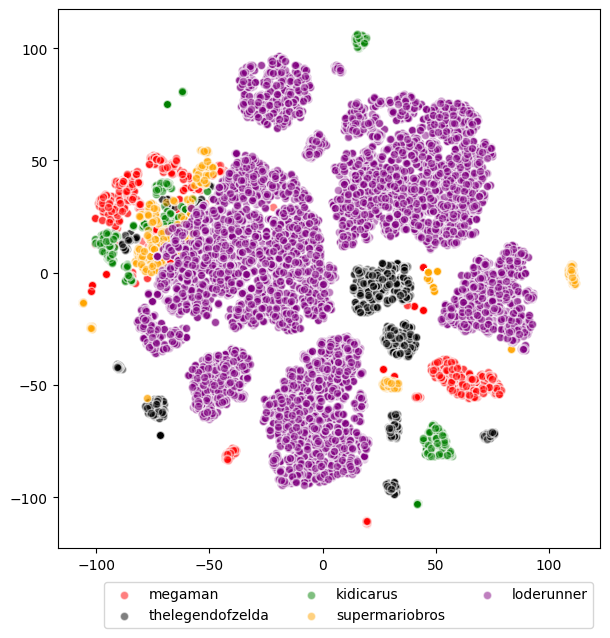

In [178]:
fig = plt.figure(figsize=(7, 7))

previousIndex = 0
colors = ["red", "black", "green", "orange", "purple"]
for i, (gamename, indexTo) in enumerate(gameNames):
    plt.scatter(fitEmbeddings[previousIndex:previousIndex+indexTo, 0], fitEmbeddings[previousIndex:previousIndex+indexTo, 1], label=gamename, c=colors[i], edgecolors='white', alpha=0.5)
    previousIndex = previousIndex+indexTo

plt.legend(ncols=3, bbox_to_anchor=(1, -0.05))
plt.show()

In [27]:
class TestModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=3)
        self.layer2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.layer3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.flattenLayer = nn.Flatten()
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.batchNorm3 = nn.BatchNorm2d(16)
        pass

    def forward(self, x):
        print("In Forward!")
        x = self.layer1(x)
        x = self.batchNorm1(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.layer2(x)
        x = self.batchNorm2(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.layer3(x)
        x = self.batchNorm3(x)
        x = nn.functional.relu(x)
        print(x.shape)

        x = self.flattenLayer(x)
        print(x.shape)

        return x

images = torch.tensor(np.random.randint(0, 255, size=(2, 3, 48, 48))).type(torch.float32)
print(images.shape)

model = TestModel()
model(images)

torch.Size([2, 3, 48, 48])
In Forward!
torch.Size([2, 32, 16, 16])
torch.Size([2, 32, 16, 16])
torch.Size([2, 16, 16, 16])
torch.Size([2, 4096])


tensor([[0.0000, 0.4615, 0.0000,  ..., 0.4742, 0.0000, 0.3100],
        [1.0771, 2.1234, 0.3187,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)